In [1]:
# /// script
# requires-python = ">=3.11"
# ///
from pathlib import Path
from datetime import datetime
import numpy as np
from PIL import Image
import imageio
import skimage
import pooch

import matplotlib.pyplot as plt
%matplotlib inline

# *Intro to digital images – Global BioImaging Data Course - Pune, India*

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HMS-IAC/GBI-india/blob/main/notebooks/02_Intro_to_Digital_Images.ipynb)


Welcome to the digital image chapter!  
Just like the previous notebook, it is **an interactive book**: read, explore, and **do**.

> **Why Images?**  
> Digital microscopy, image analysis, and machine learning all start with pixels.  
> Understanding that an image **is just pixel values** unlocks a world of quantitative analysis.

| Chapter | Concept | Why it matters |
|---------|---------|----------------|
| 0 | Importing modules | Using the Python ecosystem
| 1 | Pixels as Arrays | Images are numbers you can compute on |
| 2 | Loading & Display | Bring real data into NumPy, visualize it |
| 3 | Image shape, dtype and channels | Dimensions, channels, and intensity histograms |
| 4 | Image filtering and enhancement | Gaussian blur, edge detection |
| 5 | File handlings and paths | Persist your results |
| 6 | Mini project | Exploring a multi-channel fluorescence microscopy image |


## 0. Importing Modules ‑ Using the ecosystem

**Concept.**  
`import` pulls in modules – files containing variables, functions, classes.

Benefits:

* **Don’t reinvent the wheel** – tap into 400k+ packages on PyPI.  
* Organize **your** code into logical units.  
* Share work across projects.

Pro tip: use **virtual environments** (`venv`, `conda`) to isolate dependencies.

In [10]:
import random, statistics as stats
nums = [random.randint(1, 6) for _ in range(1000)]
print('Mean throw =', stats.mean(nums))

Mean throw = 3.478


### ✍️ Exercise: your turn!
Import `datetime` and print today’s date in ISO format.

In [11]:
from datetime import date
print(date.today().isoformat())

2025-06-14


## 1. Pixels as Arrays


**Concept: Image representation as numerical arrays**

A **digital image** is nothing more than a rectangular **grid of pixels**.  
Each pixel stores one or more numbers:

| Image type | Numbers per pixel | Typical NumPy shape |
|------------|------------------|---------------------|
| Grayscale  | **1** (pixel intensity: 0–255 8-bit, 0-4095 12-bit, 0-65535 16-bit) | `(height, width)`, 2D array|
| RGB color  | **3** (R, G, B)   | `(height, width, 3)`, 3D array |

Because the grid is regular, it maps perfectly to a **NumPy array**.

**Libraries we will use**:
- `numpy` – numerical processing
- `matplotlib` – visualization
- `skimage` – image processing


**Tiny 3 × 3 example**

```python
import numpy as np
img = np.zeros((3, 3), dtype=np.uint8)
print(img)
print("Shape:", img.shape)
```

```
[[0 0 0]
 [0 0 0]
 [0 0 0]]
Shape: (3, 3)
```

---

With NumPy you can create, inspect, and transform images with ordinary array syntax (add, multiply, slice…). These tiny examples scale up seamlessly to 1024 × 1024 microscopy images.


In [4]:
#make a 9x9 checkerboard
checkBoard = np.zeros((9,9))
checkBoard[0::2, 1::2] = 1
checkBoard[1::2, 0::2] = 1

print(checkBoard)

[[0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0.]]


Then, import [pyplot](https://matplotlib.org/api/pyplot_api.html) and [image](https://matplotlib.org/api/image_api.html) modules from the ploting library [matplotlib](https://matplotlib.org/3.1.1/api/index.html). Using it, we can display our checkerboard array in image form:

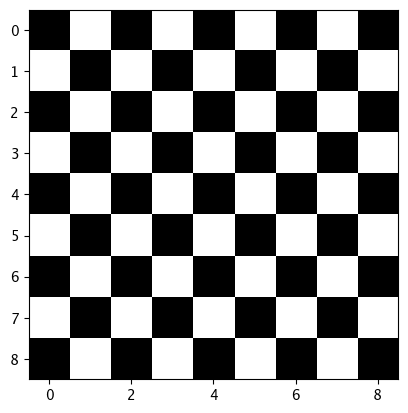

In [5]:
import matplotlib.pyplot as plt
plt.imshow(checkBoard, cmap='gray', interpolation='nearest') 
plt.show()

### ✍️ Exercise: your turn!
Create a **5 × 5** NumPy array called `blink` where the *center pixel* has value **255** and the rest are **0**.  
Print the array and its shape.

In [13]:
# write your code here

# Create a 5x5 array with center pixel set to 255
blink = np.zeros((5, 5), dtype=np.uint8)
blink[2, 2] = 255

# Print the array and its shape
print(blink)
print("Shape:", blink.shape)

[[  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0 255   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]]
Shape: (5, 5)


## 2. Loading & Displaying Real Images

**Concept.**  
Real images live on disk as **PNG/JPEG/TIFF** files, and many more formats! [Bioformats](https://www.openmicroscopy.org/bio-formats/) is a library that can load many of them. Here, we'll load an image from a URL with **imageio**, convert to a NumPy array with `np.asarray`, and plot with `matplotlib`.  

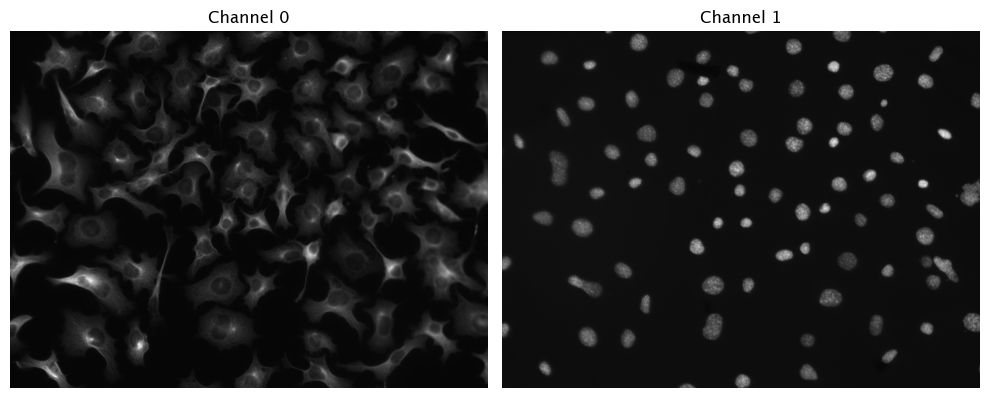

In [14]:
# load the image
try:
    from imageio.v2 import volread
except ImportError as e:
    raise ImportError(
        "Please `pip install imageio` to load cells"
    ) from e

image_url = "https://raw.githubusercontent.com/rkarmaka/sample-datasets/main/cells/cells_1.tif"
image = np.asarray(volread(image_url))

# Display
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image[0], cmap='gray')
axes[0].set_title("Channel 0")
axes[0].axis('off')

axes[1].imshow(image[1], cmap='gray')
axes[1].set_title("Channel 1")
axes[1].axis('off')

plt.tight_layout()

Let's crop the image and inspect the pixel values: 

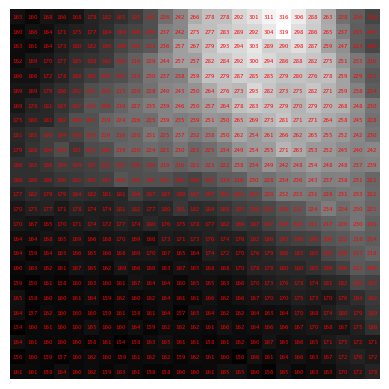

In [7]:
zoom_region = image[0, 150:175, 75:100] # around a cell boundary

plt.imshow(zoom_region, cmap='gray')
for i in range(zoom_region.shape[0]):
    for j in range(zoom_region.shape[1]):
        plt.text(j, i, f'{zoom_region[i, j]:.0f}', ha='center', va='center', color='red', fontsize=4)
plt.axis('off')
plt.show()

**Basic operations on images**

Viewing Properties

In [ ]:
print(f"Image shape: {image.shape}")
print(f"Data type: {image.dtype}")

Cropping and slicing

In [ ]:
cropped = image[0, 150:175, 75:100]
plt.imshow(cropped, cmap="gray")

Image inversion

In [ ]:
inverted = 255 - image[0]  # screens display in 8-bit RGB
plt.imshow(inverted, cmap='gray')

Rescaling intensity

In [ ]:
from skimage.exposure import rescale_intensity

rescaled = rescale_intensity(image[0], in_range=(50, 200), out_range=(0, 255))
plt.imshow(rescaled, cmap='gray')

### ✍️ Exercise: your turn!
Locate a cell by slicing the image, then print the values and the patch.

Hint: there is a cell around (100, 200)

[[112 113 111 ... 152 150 158]
 [124 119 120 ... 158 160 155]
 [134 135 137 ... 159 168 162]
 ...
 [163 159 162 ... 176 175 178]
 [163 160 156 ... 180 178 177]
 [160 163 163 ... 180 181 191]]


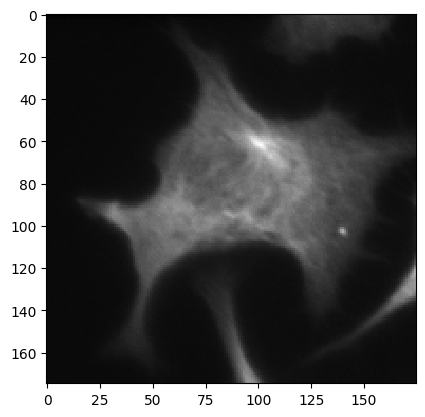

In [66]:
patch = image[0, 0:175, 50:225]
print(patch)
plt.imshow(patch, cmap='gray', interpolation='nearest') 
plt.show()

### ✍️ Exercise: your turn!
Adapt the code above to plot the composite of channels 0 and 1.

Hint: you can use `np.stack` to create the composite image.

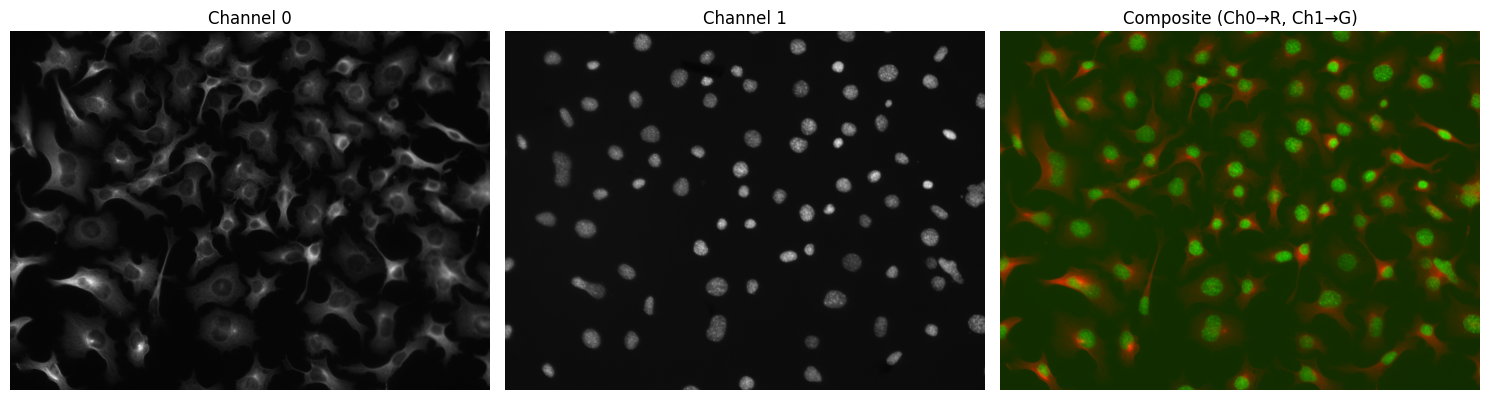

In [43]:
# write your code here

# Normalize channels to [0, 1] for display, without modifying original image
ch0 = image[0].astype(float)
ch1 = image[1].astype(float)
ch0 /= ch0.max() if ch0.max() > 0 else 1
ch1 /= ch1.max() if ch1.max() > 0 else 1

# Composite using matplotlib-compatible float RGB
composite = np.stack([ch0, ch1, np.zeros_like(ch0)], axis=-1)  # R = ch0, G = ch1, B = 0

# Plot channels and composite
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(ch0, cmap='gray')
axes[0].set_title("Channel 0")
axes[0].axis('off')

axes[1].imshow(ch1, cmap='gray')
axes[1].set_title("Channel 1")
axes[1].axis('off')

axes[2].imshow(composite)
axes[2].set_title("Composite (Ch0→R, Ch1→G)")
axes[2].axis('off')

plt.tight_layout()
plt.show()

### Cheat-sheet: manipulating images with Numpy

**Concept:** once an image is a **NumPy array**, *vectorized* math lets you transform it lightning‑fast:


* **Add / subtract** → change **brightness**  
* **Multiply / divide** → scale **contrast**  
* **Slice rows / cols** → **crop**  
* **Logical compare** → **threshold / mask**  
* **Transpose / flip** → **mirror**  
* **Power / log** → **gamma correction**  

## 3. Image shape, dtype and channels
- **shape:** tells us the size and dimensionality of the image. e.g., (512, 512) → grayscale; (512, 512, 3) → RGB
- **dtype:** data type of pixel values (e.g., uint8 for 0–255, float64 for 0–1).
- **Channels:**
    - Grayscale → 1 channel
    - RGB → 3 channels

*Why it matters: Shape and dtype affect how we process and visualize the image.*

In [11]:
print("Data type of image:", image.dtype)
print("Min, Max intensity:", image.min(), image.max())

# Normalize to float
image_float = image / 255.0
print("New dtype:", image_float.dtype)
print("New range:", image_float.min(), image_float.max())

Data type of image: uint16
Min, Max intensity: 148 1388
New dtype: float64
New range: 0.5803921568627451 5.443137254901961


Plot the pixel intensity histogram of the image:

A histogram shows how often each pixel value occurs.

Useful to:
- Understand image contrast
- Detect under/overexposed images
- Plan preprocessing steps like thresholding or normalization


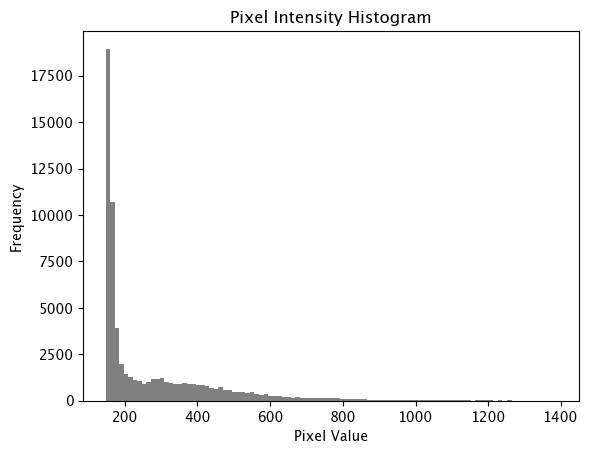

In [43]:
# Plot histogram of grayscale image
plt.hist(image[0].ravel(), bins=100, color='gray')
plt.title("Pixel Intensity Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

# use bins=256, range=(0, 255) to normalize the histogram to RGB

## 3. Image filtering and enhancement

 **Smoothing with Gaussian blur**
 
Gaussian blur is a fundamental image processing technique that:
 - Reduces noise and detail in images
 - Works by averaging each pixel with its neighbors
 - Uses a bell-shaped (Gaussian) weighting function
 - Larger blur radius = more smoothing
 - Commonly used as preprocessing for other operations

The Gaussian function gives more weight to nearby pixels and less weight to distant ones, creating a natural-looking blur effect.

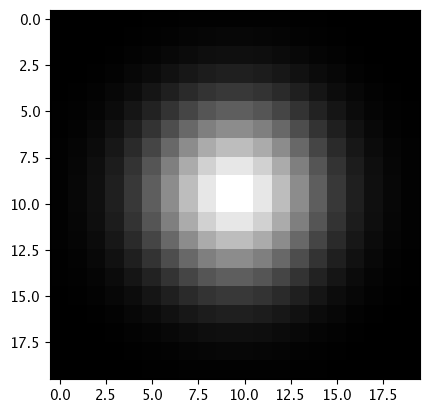

In [6]:
x = np.linspace(-3, 3, 20)
y = np.linspace(-3, 3, 20)
X, Y = np.meshgrid(x, y)
Z = np.exp(-(X**2 + Y**2) / 2) / (2 * np.pi)
plt.imshow(Z, cmap='gray')
plt.show()

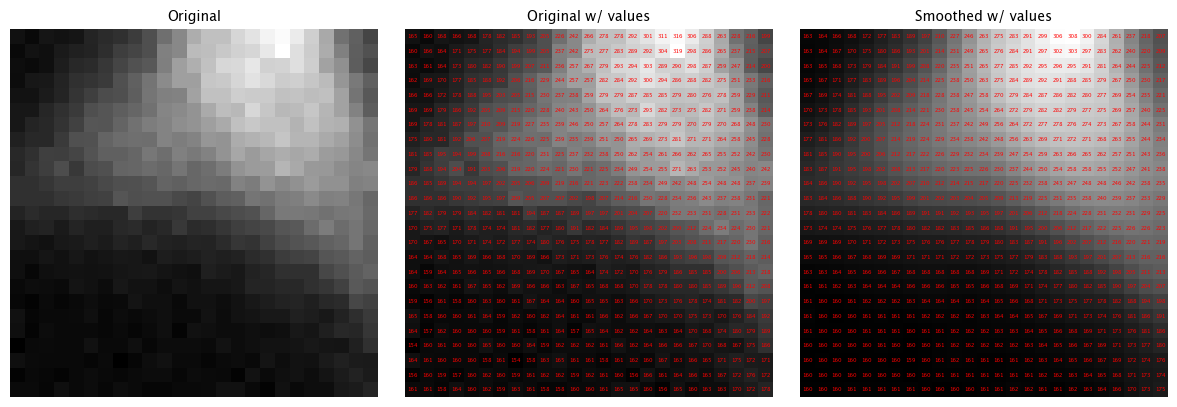

In [23]:
import matplotlib.pyplot as plt
from skimage.filters import gaussian

# around cell boundary
zoom_region = image[0, 150:175, 75:100]

# smooth the image
smooth = gaussian(zoom_region, sigma=1, preserve_range=True)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
titles = ['Original', 'Original w/ values', 'Smoothed w/ values']
images = [zoom_region, zoom_region, smooth]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title, fontsize=10)
    ax.axis('off')
    

for idx, img in enumerate([zoom_region, smooth], start=1):  # skip first image
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            val = f'{img[i, j]:.0f}'
            axes[idx].text(j, i, val, ha='center', va='center', color='red', fontsize=4)

plt.tight_layout()
plt.show()


 **Edge detection with Sobel operator**
 
The Sobel operator is a popular edge detection algorithm that:
 - Detects edges by calculating gradients in the image
 - Uses two 3x3 kernels (one for horizontal and one for vertical edges)
 - Finds both magnitude and direction of edges
 - Commonly used in image processing and computer vision tasks

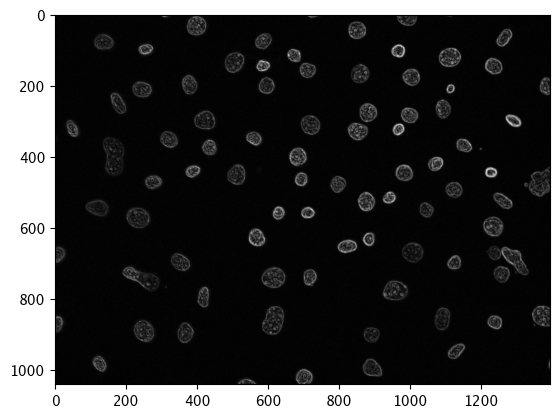

In [31]:
# the sobel operator
from skimage.filters import sobel

edges = sobel(image[1])  # on channel 1, nuclei
plt.imshow(edges, cmap='gray')

## 4. Python File Handling

**Concept.**
Files let your programs persist data.

* Use built‑in `open(path, mode)` inside a **context manager** (`with`) to ensure automatic close.  
* Modes: `'r'` read, `'w'` write (truncate), `'a'` append, `'b'` binary, `'+'` read/write.

Best practice: work with paths using `pathlib.Path`. 

In [44]:
from pathlib import Path
import time
path = Path('demo.txt')  # will create the file if it doesn't exist
with path.open('w') as f:
    f.write(f'first line {datetime.now()}\n')
    time.sleep(1)
    f.write(f'second line {datetime.now()}')

with path.open('r') as f:
    data = f.read()
    # print line by line
    for line in data.split('\n'):
        print(line)

first line 2025-06-14 13:50:56.601441
second line 2025-06-14 13:50:57.605721


Load image from a file:

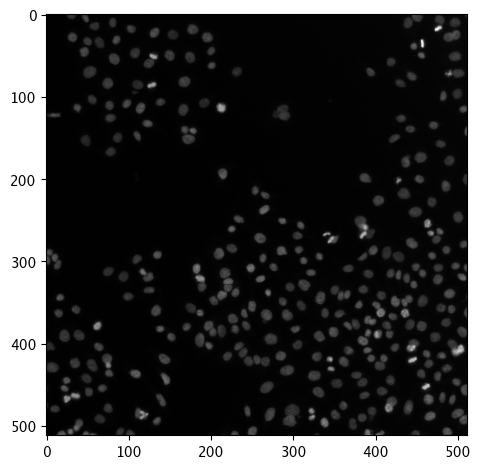

In [26]:
from skimage import data
from skimage.io import imsave
import pooch

# Load the multi-channel 3D image
image = data.human_mitosis()
# save the image
imsave('data/human_mitosis.tif', image)

# load the image
image = skimage.io.imread('data/human_mitosis.tif')
# Display
plt.imshow(image, cmap='gray')
plt.tight_layout()

Accessing metadata:

In [27]:
img_reader = imageio.get_reader('data/human_mitosis.tif', format='tif')

# Get metadata for the first frame
metadata = img_reader.get_meta_data(index=0)

# Print structured summary
print("📄 TIFF Metadata Summary:\n")
for key, value in metadata.items():
    # Truncate long values for readability
    display_value = str(value)
    if len(display_value) > 100:
        display_value = display_value[:100] + '...'
    print(f"{key:25}: {display_value}")


📄 TIFF Metadata Summary:

ImageWidth               : 512
ImageLength              : 512
BitsPerSample            : 8
Compression              : 1
PhotometricInterpretation: 1
ImageDescription         : {"shape": [512, 512]}
StripOffsets             : (256,)
SamplesPerPixel          : 1
RowsPerStrip             : 512
StripByteCounts          : (262144,)
XResolution              : (1, 1)
YResolution              : (1, 1)
ResolutionUnit           : 1
Software                 : tifffile.py
planar_configuration     : 1
compression              : 1
predictor                : 1
orientation              : None
description1             : 
description              : {"shape": [512, 512]}
software                 : tifffile.py
resolution_unit          : 1
resolution               : (1.0, 1.0)
datetime                 : None


### ✍️ Exercise: your turn!
Smooth the image and save it to disk.

Hint: use `skimage.io.imsave` to save the image.

In [11]:
# load libraries
from skimage.filters import gaussian
from skimage.io import imsave

# smooth the image
smooth = gaussian(image[1], sigma=2, preserve_range=True)  # note the importance of preserve_range to maintain the raw pixel values

# save the image
imsave('data/cells_smooth.tif', smooth)

To check the result, you can load the image and display it:

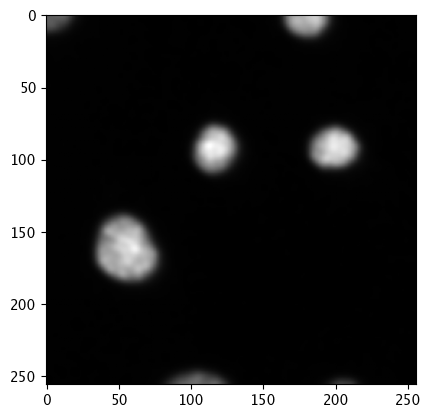

In [12]:
# load the image
image_smooth = skimage.io.imread('data/cells_smooth.tif')

# display the image
plt.imshow(image_smooth, cmap='gray')
plt.show()

## 6. Mini project: Exploring a multi-channel fluorescence microscopy image

In this mini project, we will:
1. Load and examine a 3D multi-channel fluorescence microscopy image
2. Calculate basic statistics for each channel
3. Visualize the distribution of intensities
4. Create maximum intensity projections

First, let's load the image and examine its structure:

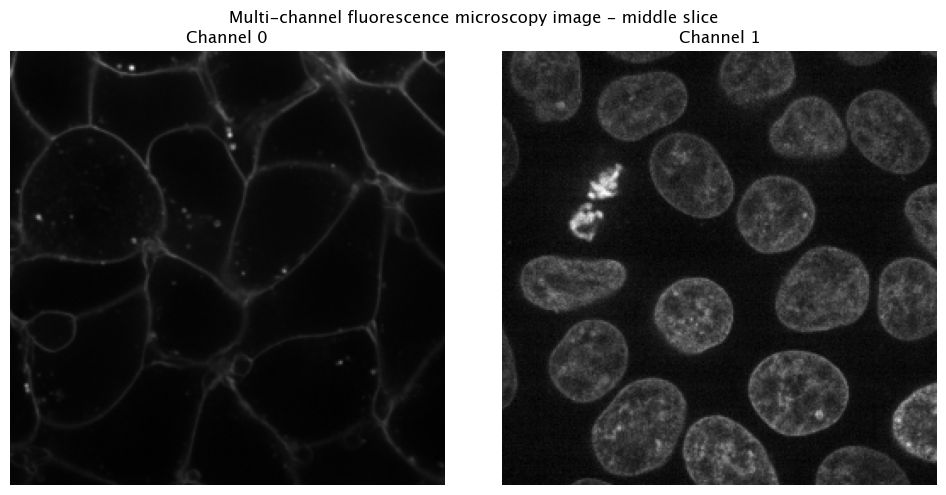

In [15]:
from skimage import data
import pooch

# Load the multi-channel 3D image
image = data.cells3d()  # 3D stack, one channel

# display the channels
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Multi-channel fluorescence microscopy image - middle slice')

# Display each channel from the middle z-slice
middle_z = image.shape[0] // 2
for channel in range(2):
    axes[channel].imshow(image[middle_z, channel, :, :], cmap='gray')
    axes[channel].set_title(f'Channel {channel}')
    axes[channel].axis('off')

plt.tight_layout()
plt.show()

In [16]:
# Print basic information about the data
print(f"Image dimensions: {image.shape}")
print(f"Number of z-slices: {image.shape[0]}")
print(f"Number of channels: {image.shape[1]}")
print(f"Image size (height × width): {image.shape[2]} × {image.shape[3]}")

# Calculate statistics for each channel
for channel in range(image.shape[1]):
    channel_data = image[:, channel, :, :]
    print(f"\nChannel {channel} statistics:")
    print(f"Mean intensity: {np.mean(channel_data):.2f}")
    print(f"Standard deviation: {np.std(channel_data):.2f}")
    print(f"Min intensity: {np.min(channel_data)}")
    print(f"Max intensity: {np.max(channel_data)}")

Image dimensions: (60, 2, 256, 256)
Number of z-slices: 60
Number of channels: 2
Image size (height × width): 256 × 256

Channel 0 statistics:
Mean intensity: 2659.64
Standard deviation: 1977.23
Min intensity: 0
Max intensity: 65535

Channel 1 statistics:
Mean intensity: 7014.64
Standard deviation: 4286.44
Min intensity: 0
Max intensity: 65535


Save the image to disk for later use:

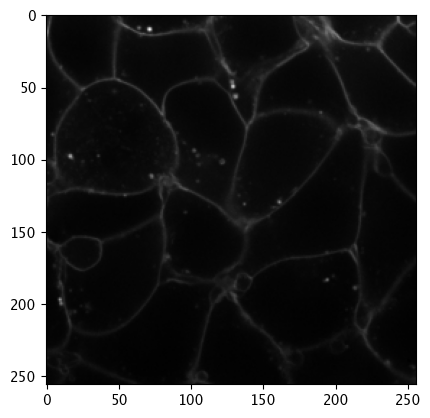

In [18]:
# save the image as tiff
from skimage.io import imsave
imsave('data/cells3d.tif', image)

# load the image
image_loaded = skimage.io.imread('data/cells3d.tif')

# display the image
plt.imshow(image_loaded[30, 0, :, :], cmap='gray')

## 7. Visualizing images with napari

**Introduction to napari**

napari is a fast, interactive, multi-dimensional image viewer for Python. It supports:
- 2D, 3D, and time-series images.
- Viewing raw images and masks simultaneously.
- Interactive contrast adjustment, zooming, and layer management.
- It is particularly useful for microscopy images and segmentation tasks.

How to install napari:

For now, we will install napari using the asset system as a bundled app.

Go to https://github.com/napari/napari/releases/tag/v0.6.1, and install the appropriate version for your operating system.
